In [ ]:
import pandas as pd
import numpy as np
import requests
from googleapiclient.discovery import build
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
api_key = ''

In [ ]:
#!pip install --upgrade google-api-python-client

In [ ]:
channel_id = ''
api_key = ''

youtube = build('youtube','v3',developerKey = api_key)

In [ ]:
def get_channel(youtube,channel_id):


    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=channel_id)

    response = request.execute()

    data = {'channelName': response['items'][0]['snippet']['title'],
                'subscribers': response['items'][0]['statistics']['subscriberCount'],
                'views': response['items'][0]['statistics']['viewCount'],
                'totalVideos': response['items'][0]['statistics']['videoCount'],
                'playlistId': response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
        }

    return data

In [ ]:
channel_stats = get_channel(youtube,channel_id)

In [ ]:
channel_data = pd.DataFrame(channel_stats,index=[0])

In [ ]:
playlist_id = ''

In [ ]:
def get_video_ids(youtube, playlist_id):

    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    return video_ids


def get_video_details(youtube, video_ids):

   all_video_info = []

   for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)

   return pd.DataFrame(all_video_info)

In [ ]:
video_ids = get_video_ids(youtube, playlist_id)

In [ ]:
len(video_ids)

862

In [ ]:
video_df = get_video_details(youtube, video_ids)
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,-rrYftR8UeA,Ali Abdaal,Is it time to grow up? 🧸,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal, feel good productivity...",2024-04-06T12:00:00Z,7912,738,None,4,PT54S,hd,false
1,bEUZTZ6kBBs,Ali Abdaal,The danger of self-imposed pressure 🫵🏽,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal, feel good productivity...",2024-04-05T12:00:29Z,14338,1005,None,9,PT56S,hd,false
2,De_Zs3g5JT4,Ali Abdaal,Watch this if you're feeling drained 🫠,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal, feel good productivity...",2024-04-04T12:00:17Z,18609,1716,None,13,PT45S,hd,false
3,IJwuAm3fEWg,Ali Abdaal,The Batman Effect 🦇,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal, feel good productivity...",2024-04-03T12:00:14Z,21431,1440,None,22,PT42S,hd,false
4,MoGTXsusX6Q,Ali Abdaal,Change Your Life by Journalling - 10 Powerful ...,Use the promo code ALI to get a free share wor...,"[Ali Abdaal, Ali abdal, journalling, journalin...",2024-04-02T14:45:00Z,128174,6128,None,231,PT22M7S,hd,false


# Data Pre-processing

In [ ]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        862 non-null    object
 1   channelTitle    862 non-null    object
 2   title           862 non-null    object
 3   description     862 non-null    object
 4   tags            840 non-null    object
 5   publishedAt     862 non-null    object
 6   viewCount       862 non-null    object
 7   likeCount       862 non-null    object
 8   favouriteCount  0 non-null      object
 9   commentCount    862 non-null    object
 10  duration        862 non-null    object
 11  definition      862 non-null    object
 12  caption         862 non-null    object
dtypes: object(13)
memory usage: 87.7+ KB


In [ ]:
# converting columns to integer type
num_col = ['viewCount','likeCount','favouriteCount','commentCount']
video_df[num_col] = video_df[num_col].apply(pd.to_numeric,errors='coerce',axis = 1)

In [ ]:
# parse the publishedAt column
from datetime import datetime

def parse_time(timestamp):
  dt = datetime.fromisoformat(timestamp.replace('Z', '+00:00'))
  return dt.day,dt.month,dt.year

video_df['Day'],video_df['Month'],video_df['Year'] = zip(*video_df['publishedAt'].apply(parse_time))

In [ ]:
!pip install isodate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.5 MB/s eta 0:00:00


In [ ]:
# convert duration to seconds
import isodate

def parse_duration(duration):
    dur = isodate.parse_duration(duration)
    return dur.total_seconds()

video_df['total_seconds'] = video_df['duration'].apply(lambda x: parse_duration(x))


In [ ]:
# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [ ]:
video_df.head(3)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,Day,Month,Year,total_seconds,tagsCount
0,-rrYftR8UeA,Ali Abdaal,Is it time to grow up? 🧸,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal, feel good productivity...",2024-04-06T12:00:00Z,7912.0,738.0,NaN,4.0,PT54S,hd,false,6,4,2024,54.0,4
1,bEUZTZ6kBBs,Ali Abdaal,The danger of self-imposed pressure 🫵🏽,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal, feel good productivity...",2024-04-05T12:00:29Z,14338.0,1005.0,NaN,9.0,PT56S,hd,false,5,4,2024,56.0,5
2,De_Zs3g5JT4,Ali Abdaal,Watch this if you're feeling drained 🫠,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal, feel good productivity...",2024-04-04T12:00:17Z,18609.0,1716.0,NaN,13.0,PT45S,hd,false,4,4,2024,45.0,6


# Data Analysis

<ipython-input-27-0387091f37b0>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = 'title',y = 'viewCount',data = video_df.sort_values('viewCount',ascending=False)[0:19],palette=colors)
<ipython-input-27-0387091f37b0>:4: UserWarning: The palette list has more values (862) than needed (19), which may not be intended.
  ax = sns.barplot(x = 'title',y = 'viewCount',data = video_df.sort_values('viewCount',ascending=False)[0:19],palette=colors)
<ipython-input-27-0387091f37b0>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 129297 (\N{MONEY-MOUTH FACE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylab

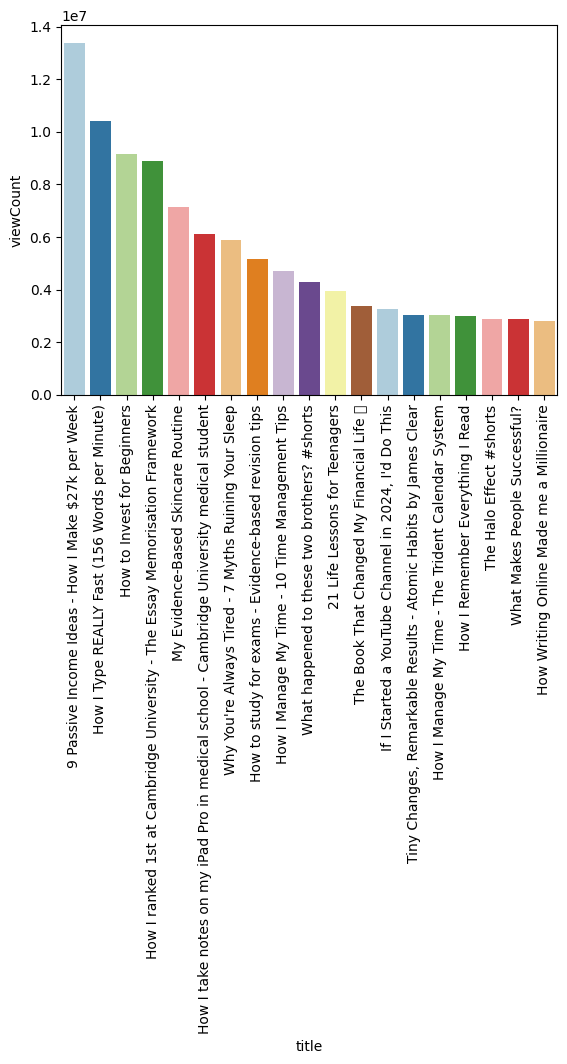

In [ ]:
# Which one is the most popular video ?

colors = sns.color_palette('Paired', n_colors=len(video_df))
ax = sns.barplot(x = 'title',y = 'viewCount',data = video_df.sort_values('viewCount',ascending=False)[0:19],palette=colors)
plt = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)


<ipython-input-34-8b68f6019469>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = 'title',y = 'likeCount',data = video_df.sort_values('likeCount',ascending=False)[0:19],palette=colors)
<ipython-input-34-8b68f6019469>:2: UserWarning: The palette list has more values (862) than needed (19), which may not be intended.
  ax = sns.barplot(x = 'title',y = 'likeCount',data = video_df.sort_values('likeCount',ascending=False)[0:19],palette=colors)
<ipython-input-34-8b68f6019469>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 129496 (\N{PERSON IN LOTUS POSITION}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/co

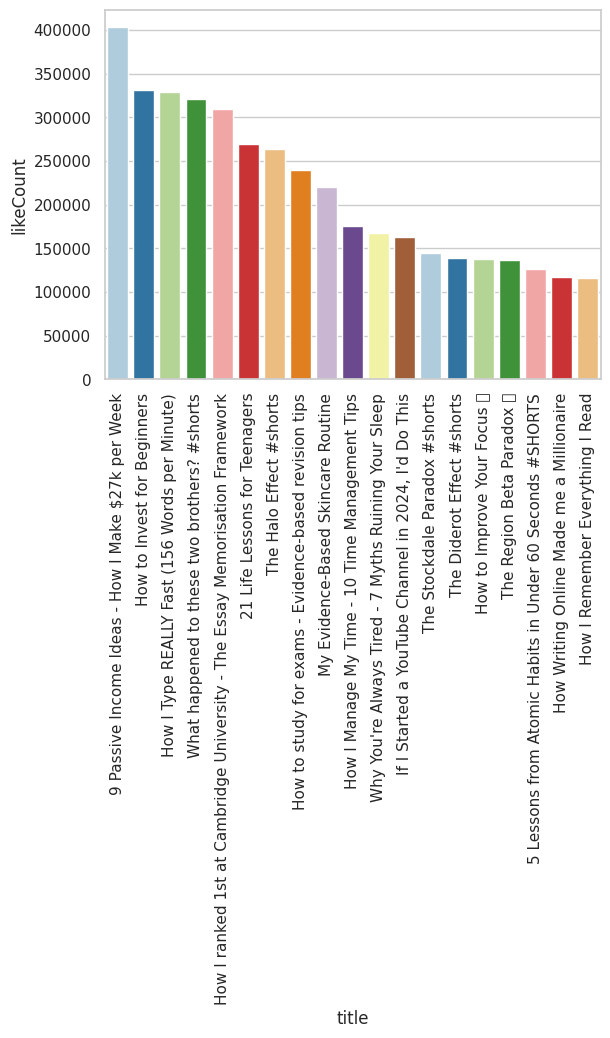

In [ ]:
colors = sns.color_palette('Paired', n_colors=len(video_df))
ax = sns.barplot(x = 'title',y = 'likeCount',data = video_df.sort_values('likeCount',ascending=False)[0:19],palette=colors)
plt = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# From above two analysis we can say that in most videos which are getting higher viewcount are also getting higher number of like count.

<ipython-input-33-43da79ccf159>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=90)


[Text(-50000.0, 0, '-50000.0'),
 Text(0.0, 0, '0.0'),
 Text(50000.0, 0, '50000.0'),
 Text(100000.0, 0, '100000.0'),
 Text(150000.0, 0, '150000.0'),
 Text(200000.0, 0, '200000.0'),
 Text(250000.0, 0, '250000.0'),
 Text(300000.0, 0, '300000.0'),
 Text(350000.0, 0, '350000.0'),
 Text(400000.0, 0, '400000.0'),
 Text(450000.0, 0, '450000.0')]

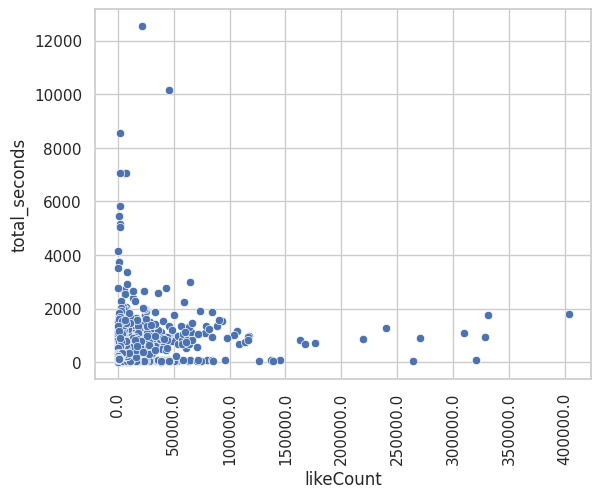

In [ ]:
sns.set(style='whitegrid')
ax = sns.scatterplot(x = 'likeCount',y = 'total_seconds',data =video_df)
ax.set_xticklabels(ax.get_xticks(), rotation=90)


# From the above observation we can say that as the duration of video is increasing the like counts are not.

# This shows that people like to watch and like those videos which are less than 2000 seconds.

In [ ]:
video_per_month = video_df.groupby('Month',as_index=False).size()
video_per_year = video_df.groupby('Year',as_index=False).size()

# In year 2023 , highest amount of videos are uploaded.

<Axes: xlabel='Year', ylabel='size'>

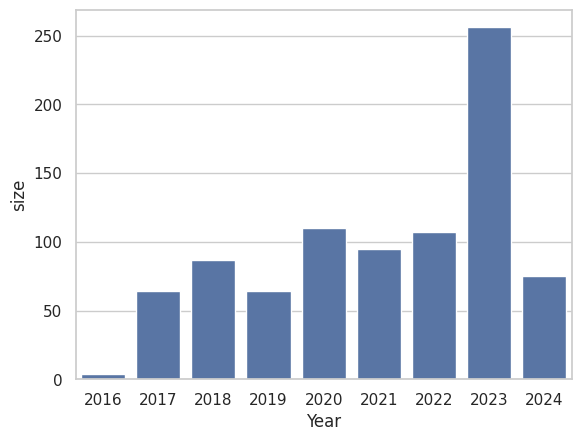

In [ ]:
sns.barplot(x='Year',y = 'size',data=video_per_year)

#In both the months March and December highest number of videos are uploaded.

<Axes: xlabel='Month', ylabel='size'>

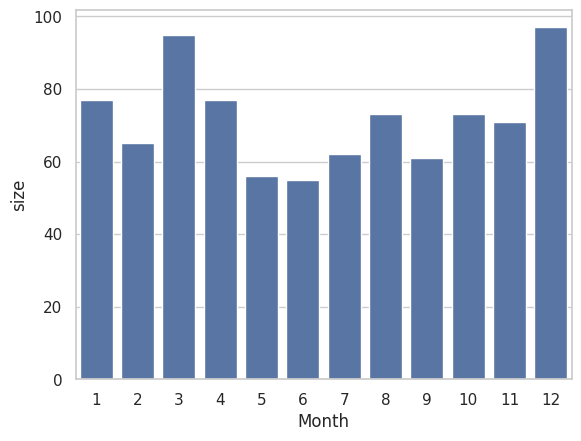

In [ ]:
sns.barplot(x='Month',y = 'size',data=video_per_month)

<Axes: xlabel='Year', ylabel='viewCount'>

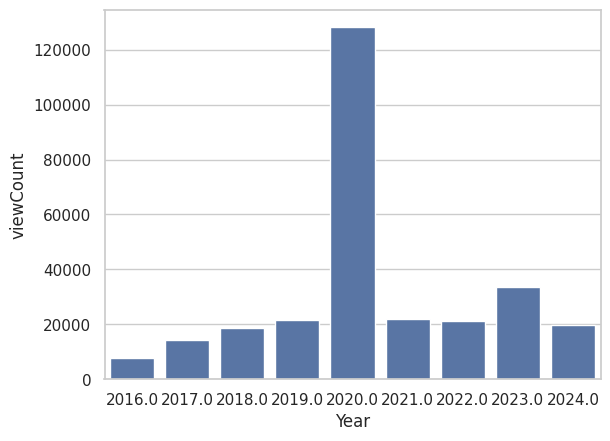

In [ ]:
sns.barplot(x='Year',y = video_df['viewCount'],data=video_per_year)

# From the above graph we can see that year 2020 has highest number of viewcount. So, we can easily say that during covid pandamic people tend to watch more youtube videos.

<Axes: xlabel='Month', ylabel='viewCount'>

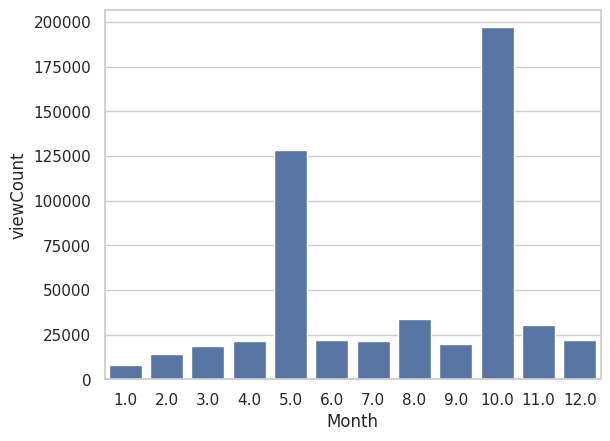

In [ ]:
sns.barplot(x='Month',y = video_df['viewCount'],data=video_per_month)

# From above graph we can say that in month of October and May the viewcount has spiked up.